# Structure from Motion

Structure from Motion (SFM or SfM) is very similar to SLAM, except we are trying to estimate the pose of several cameras observing a set of unknown 3D landmarks.


In [1]:
%pip - q install gtsam == 4.2a5


ERROR: unknown command "-"
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gtsam
import matplotlib.pyplot as plt
import numpy as np
from gtsam import symbol_shorthand
L = symbol_shorthand.L
X = symbol_shorthand.X

from gtsam.examples import SFMdata
from gtsam import (Cal3_S2, DoglegOptimizer,
                         GenericProjectionFactorCal3_S2, Marginals,
                         NonlinearFactorGraph, PinholeCameraCal3_S2, Point3,
                         Pose3, PriorFactorPoint3, PriorFactorPose3, Rot3, Values)
from gtsam.utils import plot
%matplotlib inline

Camera observations of landmarks (i.e. pixel coordinates) will be stored as Point2 (x, y).

Each variable in the system (poses and landmarks) must be identified with a unique key.
We can either use simple integer keys (1, 2, 3, ...) or symbols (X1, X2, L1).
Here we will use Symbols

In GTSAM, measurement functions are represented as 'factors'. Several common factors
have been provided with the library for solving robotics/SLAM/Bundle Adjustment problems.
Here we will use Projection factors to model the camera's landmark observations.
Also, we will initialize the robot at some location using a Prior factor.

When the factors are created, we will add them to a Factor Graph. As the factors we are using
are nonlinear factors, we will need a Nonlinear Factor Graph.

Finally, once all of the factors have been added to our factor graph, we will want to
solve/optimize to graph to find the best (Maximum A Posteriori) set of variable values.
GTSAM includes several nonlinear optimizers to perform this step. Here we will use a
trust-region method known as Powell's Degleg

The nonlinear solvers within GTSAM are iterative solvers, meaning they linearize the
nonlinear functions around an initial linearization point, then solve the linear system
to update the linearization point. This happens repeatedly until the solver converges
to a consistent set of variable values. This requires us to specify an initial guess
for each variable, held in a Values container.


In [3]:

# Define the camera calibration parameters
K = Cal3_S2(50.0, 50.0, 0.0, 50.0, 50.0)

# Define the camera observation noise model
measurement_noise = gtsam.noiseModel.Isotropic.Sigma(
    2, 1.0)  # one pixel in u and v

# Create the set of ground-truth landmarks
points = SFMdata.createPoints()

# Create the set of ground-truth poses
poses = SFMdata.createPoses(K)

In [4]:
# Create a factor graph
graph = NonlinearFactorGraph()

# Add a prior on pose x1. This indirectly specifies where the origin is.
# 0.3 rad std on roll,pitch,yaw and 0.1m on x,y,z
pose_noise = gtsam.noiseModel.Diagonal.Sigmas(
     np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
factor = PriorFactorPose3(X(0), poses[0], pose_noise)
graph.push_back(factor)

# Simulated measurements from each camera pose, adding them to the factor graph
for i, pose in enumerate(poses):
    camera = PinholeCameraCal3_S2(pose, K)
    for j, point in enumerate(points):
        measurement = camera.project(point)
        factor = GenericProjectionFactorCal3_S2(
            measurement, measurement_noise, X(i), L(j), K)
        graph.push_back(factor)

Because the structure-from-motion problem has a scale ambiguity, the problem is still under-constrained
Here we add a prior on the position of the first landmark. This fixes the scale by indicating the distance
between the first camera and the first landmark. All other landmark positions are interpreted using this scale.


In [5]:
point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)
factor = PriorFactorPoint3(L(0), points[0], point_noise)
graph.push_back(factor)
graph.print('Factor Graph:\n')

Factor Graph:
size: 66

Factor 0: PriorFactor on x0
  prior mean:  R: [
	0, 0.242536, -0.970143;
	1, -0, 0;
	-0, -0.970143, -0.242536
]
t: 40  0 10
  noise model: diagonal sigmas [0.3; 0.3; 0.3; 0.1; 0.1; 0.1];

Factor 1: GenericProjectionFactor, z = [
	67.1796068;
	37.5
]
  keys = { x0 l0 }
  noise model: unit (2) 

Factor 2: GenericProjectionFactor, z = [
	60.3077641;
	37.5
]
  keys = { x0 l1 }
  noise model: unit (2) 

Factor 3: GenericProjectionFactor, z = [
	39.6922359;
	37.5
]
  keys = { x0 l2 }
  noise model: unit (2) 

Factor 4: GenericProjectionFactor, z = [
	32.8203932;
	37.5
]
  keys = { x0 l3 }
  noise model: unit (2) 

Factor 5: GenericProjectionFactor, z = [
	64.7253772;
	67.8571429
]
  keys = { x0 l4 }
  noise model: unit (2) 

Factor 6: GenericProjectionFactor, z = [
	59.3706946;
	56.8181818
]
  keys = { x0 l5 }
  noise model: unit (2) 

Factor 7: GenericProjectionFactor, z = [
	40.6293054;
	56.8181818
]
  keys = { x0 l6 }
  noise model: unit (2) 

Factor 8: GenericProj

Create the data structure to hold the initial estimate to the solution
Intentionally initialize the variables off from the ground truth

In [6]:
initial_estimate = Values()
for i, pose in enumerate(poses):
    transformed_pose = pose.retract(0.1*np.random.randn(6, 1))
    initial_estimate.insert(X(i), transformed_pose)
for j, point in enumerate(points):
    transformed_point = point + 0.1*np.random.randn(3)
    initial_estimate.insert(L(j), transformed_point)
initial_estimate.print('Initial Estimates:\n')

Initial Estimates:

Values with 16 values:
Value l0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	9.86729537;
	9.99153586;
	9.82379831
]

Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-10.1133309;
	10.0099529;
	9.99434549
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-9.77263557;
	-10.0559281;
	9.9977742
]

Value l3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	9.92443404;
	-10.1036249;
	10.0858625
]

Value l4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	9.86787396;
	10.0361396;
	-9.93586051
]

Value l5: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-10.0730792;
	10.0340933;
	-9.97864231
]

Value l6: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-9.84218151;
	-9.88643437;
	-9.89115593
]

Value l7: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	9.92952336;
	-10.0191887;
	-10.0203568
]

Value x0: (gtsam::Pose3)
R: [
	-0.127007849, 0.200677098, -0.971389576;
	0.990562318, 0.07653696, -0.113703067;
	0.0515296036, -0.976663092, -0.208503966
]
t:   40.1786614 0.0362699781   9.93339

Optimize the graph and print results

In [7]:
params = gtsam.DoglegParams()
params.setVerbosity('TERMINATION')
optimizer = DoglegOptimizer(graph, initial_estimate, params)
print('Optimizing:')
result = optimizer.optimize()
result.print('Final results:\n')
print('initial error = {}'.format(graph.error(initial_estimate)))
print('final error = {}'.format(graph.error(result)))

Optimizing:
Final results:

Values with 16 values:
Value l0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	10;
	10;
	10
]
converged
errorThreshold: 1.75145933e-27 <? 0
absoluteDecrease: 5.1150933011e-13 <? 1e-05
relativeDecrease: 1 <? 1e-05
iterations: 5 >? 100

Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-10;
	10;
	10
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-10;
	-10;
	10
]

Value l3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	10;
	-10;
	10
]

Value l4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	10;
	10;
	-10
]

Value l5: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-10;
	10;
	-10
]

Value l6: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-10;
	-10;
	-10
]

Value l7: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	10;
	-10;
	-10
]

Value x0: (gtsam::Pose3)
R: [
	1.06345686108e-17, 0.242535625036, -0.970142500145;
	1, -7.01790398906e-18, 7.68207370487e-18;
	-1.28686669842e-17, -0.970142500145, -0.242535625036
]
t:                40 3.30176431837e-20                1

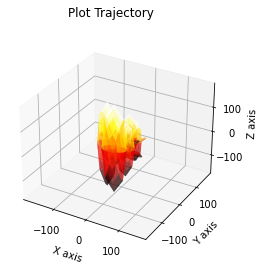

In [8]:
marginals = Marginals(graph, result)
plot.plot_3d_points(1, result, marginals=marginals)
plot.plot_trajectory(1, result, marginals=marginals, scale=8)
plot.set_axes_equal(1)
plt.show()